r=0.20, N=101, fitted ℓ=0.945, RMSE=0.026
r=0.50, N=41, fitted ℓ=1.012, RMSE=0.027
r=1.00, N=21, fitted ℓ=0.977, RMSE=0.048
r=1.60, N=13, fitted ℓ=1.037, RMSE=0.429
r=3.00, N=7, fitted ℓ=0.594, RMSE=0.834
r=5.00, N=5, fitted ℓ=1.000, RMSE=1.029


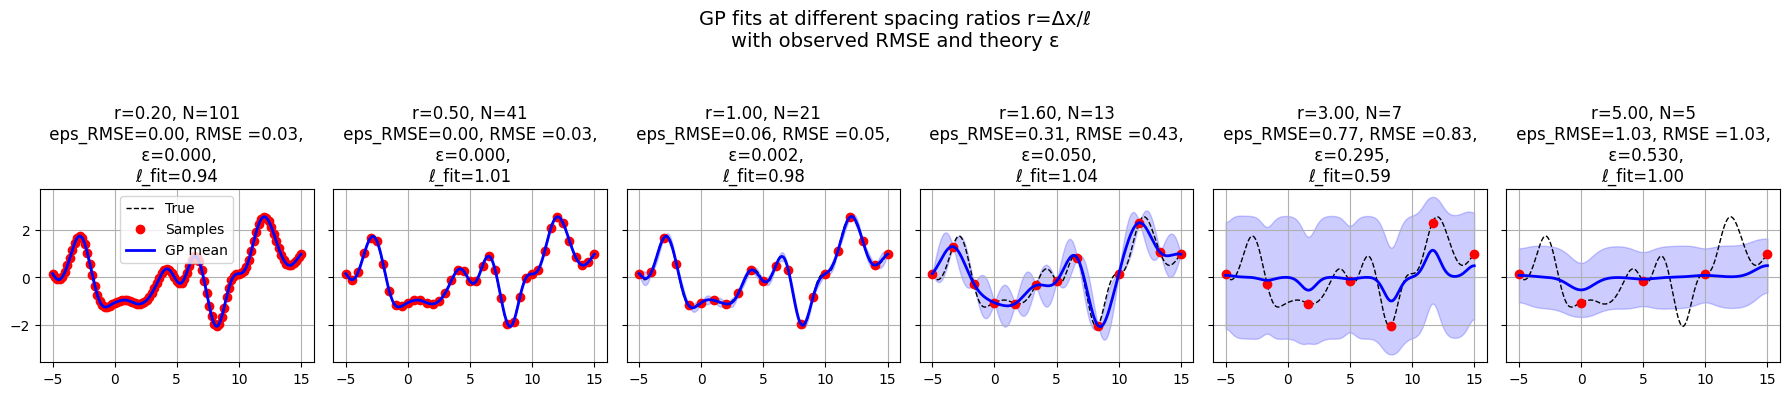

In [34]:
from math import sqrt, pi
from mpmath import erfc

# -----------------------------
# Parameters
# -----------------------------
left, right = -5, 15
L = right - left
n_fine = 500
var_true = 2.0
ell_true = 1.0
noise = 1e-6

# Fine grid
X = np.linspace(left, right, n_fine)[:, None]

# -----------------------------
# Generate one "true" GP realization
# -----------------------------
k_true = GPy.kern.RBF(input_dim=1, variance=var_true, lengthscale=ell_true)
K_true = k_true.K(X, X) + noise*np.eye(n_fine)
Y = np.random.multivariate_normal(mean=np.zeros(n_fine), cov=K_true)[:, None]

# -----------------------------
# Subsample ratios
# -----------------------------
r_values = [0.2,0.5, 1.0, 1.6, 3.0, 5.0]

# -----------------------------
# Multi-panel figure
# -----------------------------
fig, axes = plt.subplots(1, len(r_values), figsize=(18,4), sharey=True)

for i, r in enumerate(r_values):
    ax = axes[i]
    dx = r * ell_true
    N = int(np.floor(L / dx)) + 1
    X_sub = np.linspace(left, right, N)[:, None]

    idx = np.clip((X_sub - left) / L * (n_fine - 1), 0, n_fine - 1).astype(int).flatten()
    Y_sub = Y[idx]

    # Fit GP with RBF kernel
    k_fit = GPy.kern.RBF(input_dim=1)
    m = GPy.models.GPRegression(X_sub, Y_sub, k_fit)
     m.Gaussian_noise.variance.fix(1e-8)  # force noise-free interpolation
    m.optimize(messages=False)

    mu, var = m.predict(X)
    eps_rmse = np.sqrt(np.mean((mu.flatten() - Y.flatten())**2))
    rmse = np.sqrt(np.mean((mu.flatten() - Y.flatten())**2))
    # Theoretical unresolved variance fraction
    z = pi / (sqrt(2) * r)
    epsilon = float(erfc(z))   # unresolved variance fraction
    eps_rmse = np.sqrt(epsilon * var_true)  # theory floor RMSE
    # Print fitted length-scale
    ell_fit = float(m.rbf.lengthscale.values)
    print(f"r={r:.2f}, N={N}, fitted ℓ={ell_fit:.3f}, RMSE={rmse:.3f}")

    ax.plot(X, Y, 'k--', lw=1, label="True")
    ax.plot(X_sub, Y_sub, 'ro', label="Samples")
    ax.plot(X, mu, 'b-', lw=2, label="GP mean")
    ax.fill_between(X.flatten(),
                    mu.flatten() - 2*np.sqrt(var.flatten()),
                    mu.flatten() + 2*np.sqrt(var.flatten()),
                    color='blue', alpha=0.2)
    ax.set_title(f"r={r:.2f}, N={N}\n eps_RMSE={eps_rmse:.2f}, RMSE ={rmse:.2f}, \n ε={epsilon:.3f},\nℓ_fit={ell_fit:.2f}")
    ax.grid(True)
    if i == 0:
        ax.legend()

fig.suptitle("GP fits at different spacing ratios r=Δx/ℓ\nwith observed RMSE and theory ε", fontsize=14)
fig.tight_layout(rect=[0,0,1,0.92])
plt.savefig("gp_fits_with_epsilon.png", dpi=200)
plt.show()


reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.

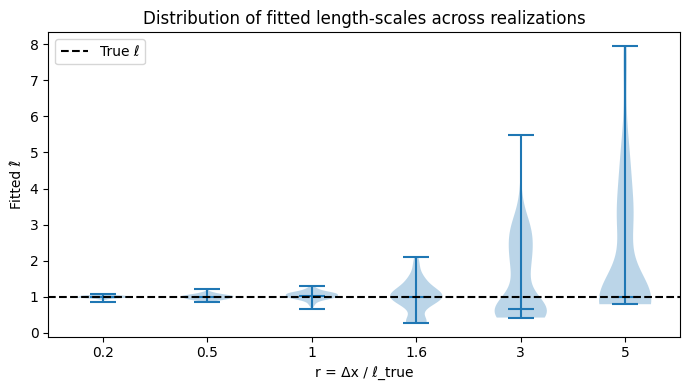

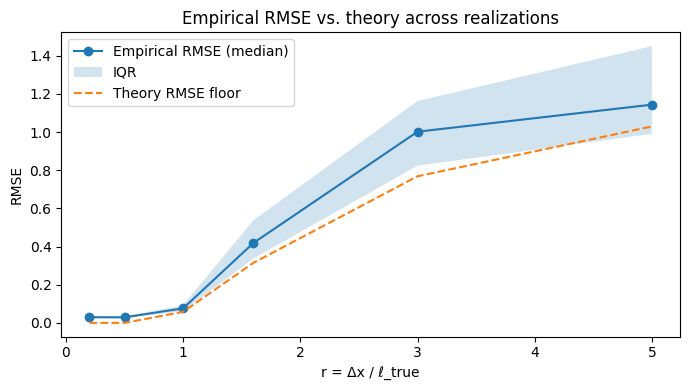

In [35]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt, pi
from mpmath import erfc
import GPy

# -----------------------------
# Parameters
# -----------------------------
left, right = -5, 15
L = right - left
n_fine = 500
var_true = 2.0
ell_true = 1.0
noise = 1e-6
r_values = [0.2, 0.5, 1.0, 1.6, 3.0, 5.0]

# Fine grid
X = np.linspace(left, right, n_fine)[:, None]

# -----------------------------
# Function: simulate one realization, fit at different r
# -----------------------------
def run_one(seed=None):
    rng = np.random.default_rng(seed)
    k_true = GPy.kern.RBF(input_dim=1, variance=var_true, lengthscale=ell_true)
    K_true = k_true.K(X, X) + noise * np.eye(n_fine)
    Y = rng.multivariate_normal(mean=np.zeros(n_fine), cov=K_true)[:, None]

    results = []
    for r in r_values:
        dx = r * ell_true
        N = int(np.floor(L / dx)) + 1
        X_sub = np.linspace(left, right, N)[:, None]

        idx = np.clip((X_sub - left) / L * (n_fine - 1), 0, n_fine - 1).astype(int).flatten()
        Y_sub = Y[idx]

        # Fit GP
        k_fit = GPy.kern.RBF(input_dim=1)
        m = GPy.models.GPRegression(X_sub, Y_sub, k_fit)
        m.Gaussian_noise.variance.constrain_bounded(1e-6, 1e-3)  # tiny but >0
        m.rbf.lengthscale.constrain_bounded(0.05, 10.0)
        m.optimize(messages=False, max_iters=1000)

        mu, var = m.predict(X)
        rmse = np.sqrt(np.mean((mu.flatten() - Y.flatten())**2))

        z = pi / (sqrt(2) * r)
        epsilon = float(erfc(z))
        rmse_theory = np.sqrt(epsilon * var_true)

        results.append(dict(r=r, N=N,
                            ell_fit=float(m.rbf.lengthscale.values),
                            rmse=rmse,
                            rmse_theory=rmse_theory,
                            epsilon=epsilon))
    return results

# -----------------------------
# Run multiple realizations
# -----------------------------
M = 100
all_results = []
for seed in range(M):
    all_results.extend(run_one(seed))

df = pd.DataFrame(all_results)

# -----------------------------
# Plot 1: violin of fitted ℓ vs r
# -----------------------------
fig, ax = plt.subplots(figsize=(7,4))
data = [df.loc[df.r==r, 'ell_fit'].values for r in r_values]
ax.violinplot(data, positions=range(len(r_values)), showmedians=True)
ax.axhline(ell_true, linestyle='--', color='k', label="True ℓ")
ax.set_xticks(range(len(r_values)))
ax.set_xticklabels([f"{r:g}" for r in r_values])
ax.set_xlabel("r = Δx / ℓ_true")
ax.set_ylabel("Fitted ℓ̂")
ax.set_title("Distribution of fitted length-scales across realizations")
ax.legend()
plt.tight_layout()
plt.savefig("violin_lengthscale.png", dpi=200)

# -----------------------------
# Plot 2: RMSE vs r with theory
# -----------------------------
g = df.groupby('r').agg(rmse_med=('rmse','median'),
                        rmse_lo=('rmse',lambda x: x.quantile(0.25)),
                        rmse_hi=('rmse',lambda x: x.quantile(0.75)),
                        rmse_th=('rmse_theory','first'))
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(g.index, g['rmse_med'], marker='o', label='Empirical RMSE (median)')
ax.fill_between(g.index, g['rmse_lo'], g['rmse_hi'], alpha=0.2, label='IQR')
ax.plot(g.index, g['rmse_th'], linestyle='--', label='Theory RMSE floor')
ax.set_xlabel("r = Δx / ℓ_true")
ax.set_ylabel("RMSE")
ax.set_title("Empirical RMSE vs. theory across realizations")
ax.legend()
plt.tight_layout()
plt.savefig("rmse_vs_theory.png", dpi=200)

# -----------------------------
# Optional: ratio plot
# -----------------------------
df['ratio'] = df['rmse'] / df['rmse_theory']
g2 = df.groupby('r').ratio.agg(['median','quantile'])
# can plot similar to above if desired

plt.show()


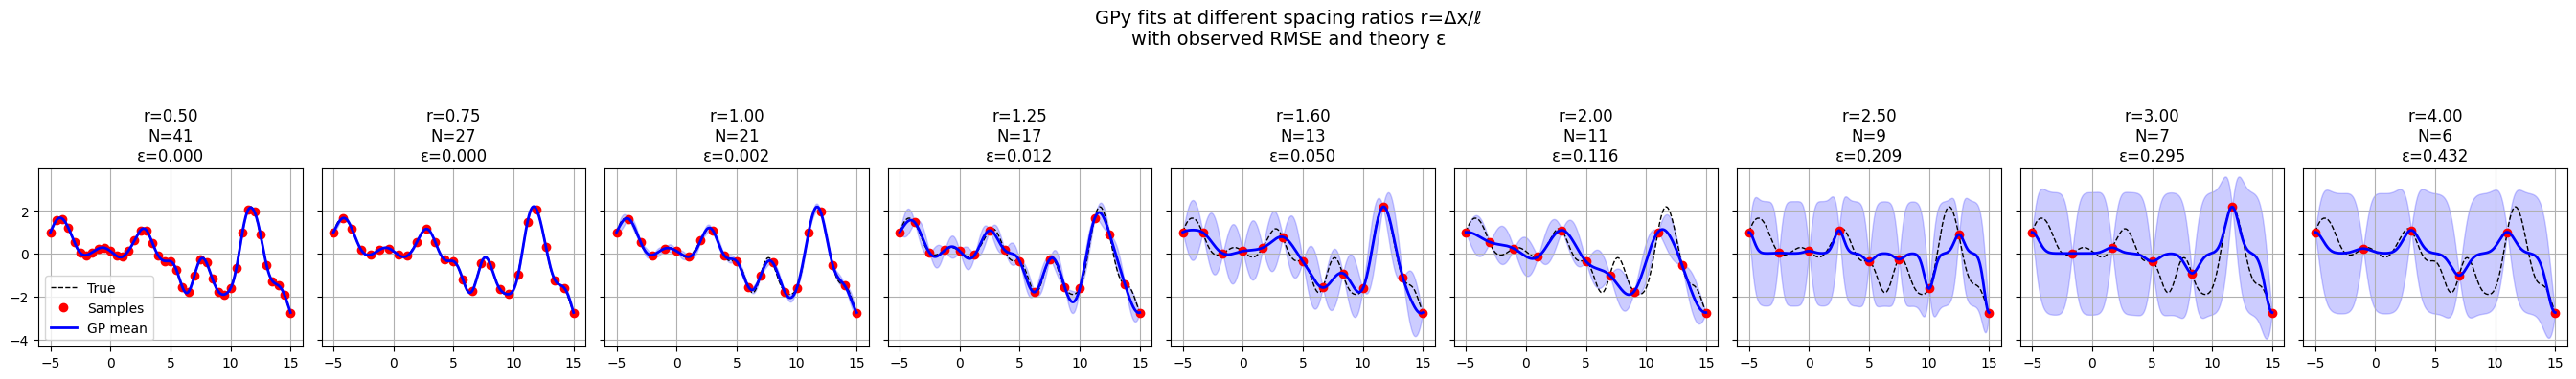

   r = Δx/ℓ    Δx  N (samples)  epsilon (theory)  \
0      0.50  0.50           41          0.000000   
1      0.75  0.75           27          0.000028   
2      1.00  1.00           21          0.001680   
3      1.25  1.25           17          0.011962   
4      1.60  1.60           13          0.049589   
5      2.00  2.00           11          0.116230   
6      2.50  2.50            9          0.208885   
7      3.00  3.00            7          0.295008   
8      4.00  4.00            6          0.432220   

   theory_floor_RMSE≈sqrt(epsilon·σ²)  observed_RMSE  recovered_%  
0                            0.000026       0.027223   100.000000  
1                            0.007489       0.030533    99.997196  
2                            0.057971       0.071900    99.831968  
3                            0.154671       0.201200    98.803837  
4                            0.314924       0.352733    95.041136  
5                            0.482141       0.587942    88.377003  
6  

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import GPy
from math import sqrt, pi
from mpmath import erfc

# -----------------------------
# Parameters
# -----------------------------
left, right = -5, 15
L = right - left
n_fine = 500
var_true = 2.0
ell_true = 1.0
noise = 1e-6

# Fine grid
X = np.linspace(left, right, n_fine)[:, None]

# -----------------------------
# Generate one "true" GP realization
# -----------------------------
k_true = GPy.kern.RBF(input_dim=1, variance=var_true, lengthscale=ell_true)
K_true = k_true.K(X, X) + noise*np.eye(n_fine)
Y = np.random.multivariate_normal(mean=np.zeros(n_fine), cov=K_true)[:, None]

# -----------------------------
# Subsample ratios
# -----------------------------
r_values = [0.5, 0.75, 1.0, 1.25, 1.6, 2.0, 2.5, 3.0, 4.0]

results = []

# -----------------------------
# Multi-panel figure
# -----------------------------
fig, axes = plt.subplots(1, len(r_values), figsize=(3*len(r_values),4), sharey=True)

for i, r in enumerate(r_values):
    ax = axes[i]
    dx = r * ell_true
    N = int(np.floor(L / dx)) + 1
    X_sub = np.linspace(left, right, N)[:, None]

    idx = np.clip((X_sub - left) / L * (n_fine - 1), 0, n_fine - 1).astype(int).flatten()
    Y_sub = Y[idx]

    # Fit GP with RBF kernel
    k_fit = GPy.kern.RBF(input_dim=1)
    m = GPy.models.GPRegression(X_sub, Y_sub, k_fit)
    m.Gaussian_noise.variance.fix(1e-8)  # force noise-free interpolation
    m.optimize(messages=False)

    mu, var = m.predict(X)
    rmse = np.sqrt(np.mean((mu.flatten() - Y.flatten())**2))

    # Theoretical unresolved variance fraction
    z = pi / (sqrt(2) * r)
    epsilon = float(erfc(z))
    eps_rmse = np.sqrt(epsilon * var_true)
    recovered = (1 - epsilon) * 100

    results.append({
        "r = Δx/ℓ": r,
        "Δx": dx,
        "N (samples)": N,
        "epsilon (theory)": epsilon,
        "theory_floor_RMSE≈sqrt(epsilon·σ²)": eps_rmse,
        "observed_RMSE": rmse,
        "recovered_%": recovered
    })

    # Plot
    ax.plot(X, Y, 'k--', lw=1, label="True")
    ax.plot(X_sub, Y_sub, 'ro', label="Samples")
    ax.plot(X, mu, 'b-', lw=2, label="GP mean")
    ax.fill_between(X.flatten(),
                    mu.flatten() - 2*np.sqrt(var.flatten()),
                    mu.flatten() + 2*np.sqrt(var.flatten()),
                    color='blue', alpha=0.2)
    ax.set_title(f"r={r:.2f}\nN={N}\nε={epsilon:.3f}")
    ax.grid(True)
    if i == 0:
        ax.legend()

fig.suptitle("GPy fits at different spacing ratios r=Δx/ℓ\nwith observed RMSE and theory ε", fontsize=14)
fig.tight_layout(rect=[0,0,1,0.9])
plt.savefig("gp_results_summary.png", dpi=200)
plt.show()

# -----------------------------
# Save table
# -----------------------------
df = pd.DataFrame(results)
df.to_csv("gp_results_summary.csv", index=False)
print(df.round(6))


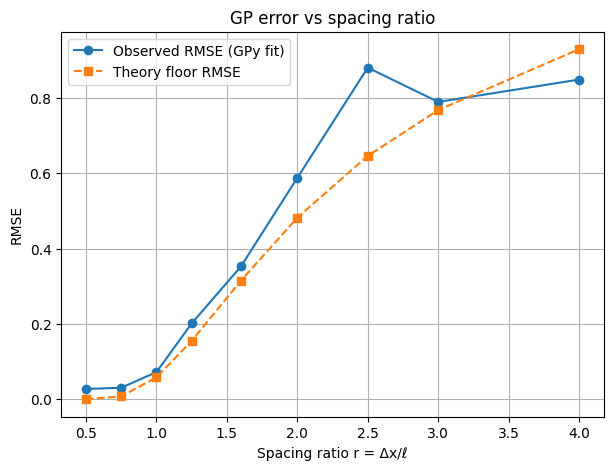

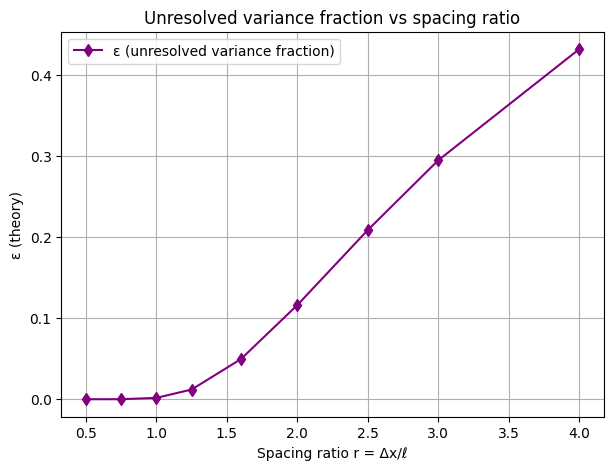

In [13]:
import matplotlib.pyplot as plt
import pandas as pd

# Example: load from your CSV
df = pd.read_csv("gp_results_summary.csv")

# Line plot: Observed RMSE vs r, with theory floor
plt.figure(figsize=(7,5))
plt.plot(df["r = Δx/ℓ"], df["observed_RMSE"], 'o-', label="Observed RMSE (GPy fit)")
plt.plot(df["r = Δx/ℓ"], df["theory_floor_RMSE≈sqrt(epsilon·σ²)"], 's--', label="Theory floor RMSE")
plt.xlabel("Spacing ratio r = Δx/ℓ")
plt.ylabel("RMSE")
plt.title("GP error vs spacing ratio")
plt.grid(True)
plt.legend()
plt.savefig("gp_lineplot_rmse.png", dpi=200)
plt.show()

# Line plot: epsilon vs r
plt.figure(figsize=(7,5))
plt.plot(df["r = Δx/ℓ"], df["epsilon (theory)"], 'd-', color="purple", label="ε (unresolved variance fraction)")
plt.xlabel("Spacing ratio r = Δx/ℓ")
plt.ylabel("ε (theory)")
plt.title("Unresolved variance fraction vs spacing ratio")
plt.grid(True)
plt.legend()
plt.savefig("gp_lineplot_epsilon.png", dpi=200)
plt.show()


In [14]:
n_trials = 50
rmse_means = []
rmse_stds = []

for r in r_values:
    rmses = []
    for _ in range(n_trials):
        # simulate GP realization, subsample, fit, predict
        # compute RMSE → append to rmses
        pass
    rmse_means.append(np.mean(rmses))
    rmse_stds.append(np.std(rmses))
  

 C:\Users\bt307587\anaconda3\envs\gpyenv\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning:Mean of empty slice.
 C:\Users\bt307587\anaconda3\envs\gpyenv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning:invalid value encountered in scalar divide
 C:\Users\bt307587\anaconda3\envs\gpyenv\lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning:Degrees of freedom <= 0 for slice
 C:\Users\bt307587\anaconda3\envs\gpyenv\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning:invalid value encountered in divide
 C:\Users\bt307587\anaconda3\envs\gpyenv\lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning:invalid value encountered in scalar divide


use posterior length scale vs use known length scale 

reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining 

    r = Δx/ℓ   Δx  N (samples)  RMSE_floor_true  RMSE_floor_marg  \
0        0.2  0.2          101         0.000000         0.000000   
1        0.5  0.5           41         0.000026         0.000111   
2        0.9  0.9           23         0.031043         0.050900   
3        1.2  1.2           17         0.133003         0.246997   
4        1.6  1.6           13         0.314924         0.660513   
5        1.9  1.9           11         0.443250         0.669826   
6        2.5  2.5            9         0.646351         0.783685   
7        3.0  3.0            7         0.768126         0.816434   
8        4.0  4.0            6         0.929753         0.808501   
9        5.0  5.0            5         1.029364         0.878638   
10       9.0  9.0            3         1.205852         1.205852   

    RMSE_floor_fit  RMSE_mean  RMSE_std  
0         0.000000   0.030969  0.008239  
1         0.000060   0.030334  0.005249  
2         0.034692   0.056865  0.011834  
3         0.176

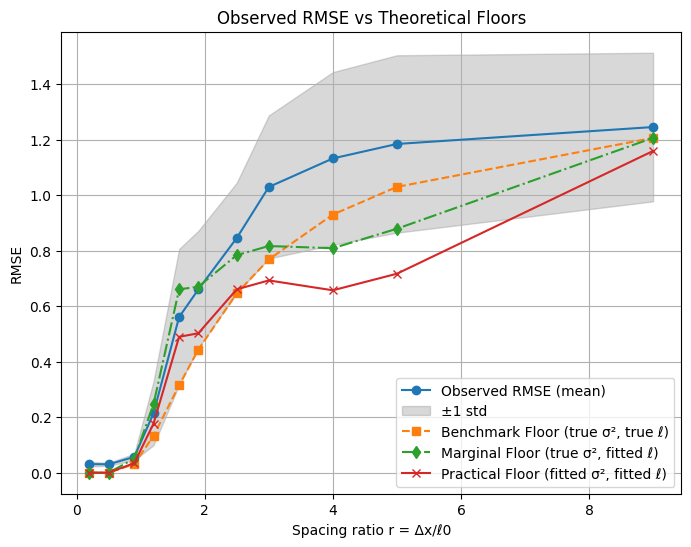

In [50]:
# -----------------------------
# Parameters
# -----------------------------
left, right = -5, 15
L = right - left
n_fine = 500
var_true = 2.0
ell_true = 1.0
noise = 1e-6
n_trials = 100

# Fine grid
X = np.linspace(left, right, n_fine)[:, None]
r_values = [0.2, 0.5, 0.9, 1.2, 1.6, 1.9, 2.5, 3.0, 4.0, 5.0, 9.0]

results = []
for r in r_values:
    dx = r * ell_true
    N = int(np.floor(L / dx)) + 1
    X_sub = np.linspace(left, right, N)[:, None]

    rmse_trials = []
    fitted_ells = []
    fitted_vars = []

    for t in range(n_trials):
        # --- Simulate one GP realization ---
        k_true = GPy.kern.RBF(input_dim=1, variance=var_true, lengthscale=ell_true)
        K_true = k_true.K(X, X) + noise*np.eye(n_fine)
        Y = np.random.multivariate_normal(mean=np.zeros(n_fine), cov=K_true)[:, None]

        # Subsample observations
        idx = np.clip((X_sub - left) / L * (n_fine - 1), 0, n_fine - 1).astype(int).flatten()
        Y_sub = Y[idx]

        # --- Fit GP ---
        k_fit = GPy.kern.RBF(input_dim=1)
        m = GPy.models.GPRegression(X_sub, Y_sub, k_fit)
        m.Gaussian_noise.variance.constrain_bounded(1e-6, 1e-3)  # small nugget >0
        m.rbf.lengthscale.constrain_bounded(0.05, 10.0)
        m.rbf.variance.constrain_bounded(0.1, 10.0)
        m.optimize(messages=False)

        mu, var = m.predict(X)
        rmse = np.sqrt(np.mean((mu.flatten() - Y.flatten())**2))
        rmse_trials.append(rmse)
        fitted_ells.append(float(m.rbf.lengthscale))
        fitted_vars.append(float(m.rbf.variance))

    # --- Theory with true ℓ & true σ² ---
    z = pi / (sqrt(2) * r)
    epsilon_true = float(erfc(z))
    eps_rmse_true = np.sqrt(epsilon_true * var_true)

    # --- Floor using fitted ℓ (marginalized), but true σ² ---
    eps_marg = np.mean([float(erfc(pi/(sqrt(2)*r) * (ell_hat/ell_true)))
                        for ell_hat in fitted_ells])
    eps_rmse_marg = np.sqrt(eps_marg * var_true)

    # --- Floor using fitted ℓ AND fitted σ² ---
    eps_rmse_fit = np.mean([
        np.sqrt(float(erfc(pi/(sqrt(2)*r) * (ell_hat/ell_true))) * var_hat)
        for ell_hat, var_hat in zip(fitted_ells, fitted_vars)
    ])

    # --- Observed RMSE ---
    rmse_mean = np.mean(rmse_trials)
    rmse_std = np.std(rmse_trials)

    results.append({
        "r = Δx/ℓ": r,
        "Δx": dx,
        "N (samples)": N,
        "RMSE_floor_true": eps_rmse_true,
        "RMSE_floor_marg": eps_rmse_marg,
        "RMSE_floor_fit": eps_rmse_fit,
        "RMSE_mean": rmse_mean,
        "RMSE_std": rmse_std
    })

# -----------------------------
# Save results
# -----------------------------
df = pd.DataFrame(results)
df.to_csv("gp_results_with_var.csv", index=False)
print(df.round(6))

# -----------------------------
# Plot with three floors
# -----------------------------
plt.figure(figsize=(8,6))
plt.plot(df["r = Δx/ℓ"], df["RMSE_mean"], 'o-', label="Observed RMSE (mean)")
plt.fill_between(df["r = Δx/ℓ"],
                 df["RMSE_mean"]-df["RMSE_std"],
                 df["RMSE_mean"]+df["RMSE_std"],
                 color="gray", alpha=0.3, label="±1 std")

plt.plot(df["r = Δx/ℓ"], df["RMSE_floor_true"], 's--', label="Benchmark Floor (true σ², true ℓ)")
plt.plot(df["r = Δx/ℓ"], df["RMSE_floor_marg"], 'd-.', label="Marginal Floor (true σ², fitted ℓ)")
plt.plot(df["r = Δx/ℓ"], df["RMSE_floor_fit"], 'x-', label="Practical Floor (fitted σ², fitted ℓ)")

plt.xlabel("Spacing ratio r = Δx/ℓ0")
plt.ylabel("RMSE")
plt.title("Observed RMSE vs Theoretical Floors")
plt.grid(True)
plt.legend()
plt.savefig("gp_lineplot_rmse_with_var.png", dpi=200, bbox_inches="tight")
plt.show()


reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining parameters GP_regression.rbf.variance
reconstraining parameters GP_regression.Gaussian_noise.variance
reconstraining parameters GP_regression.rbf.lengthscale
reconstraining 

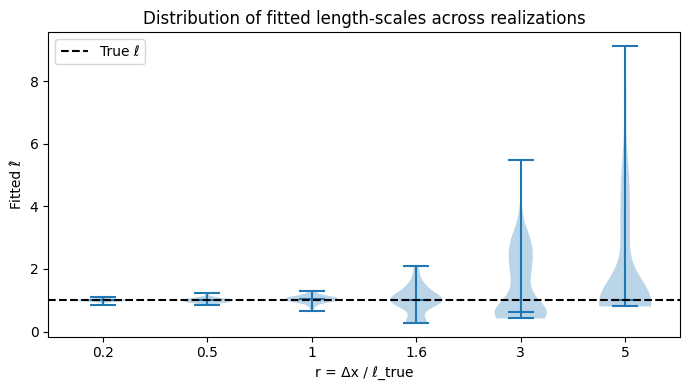

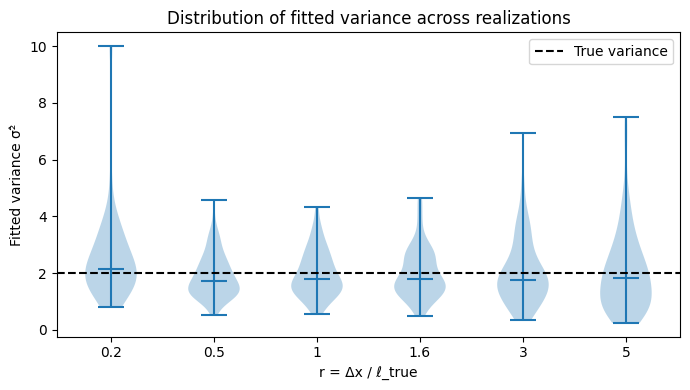

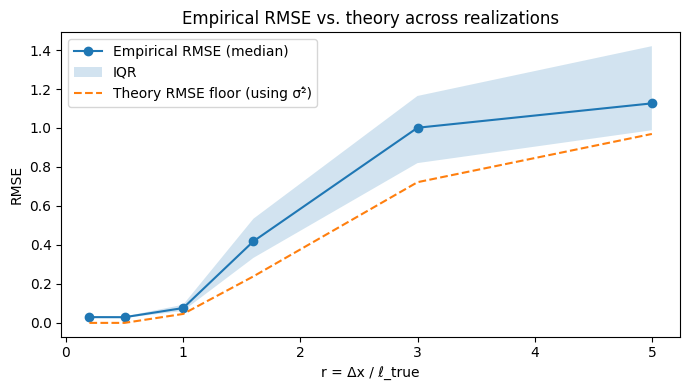

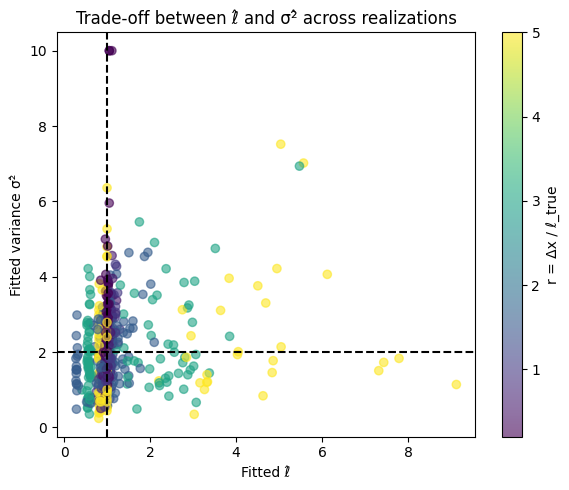

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import sqrt, pi
from mpmath import erfc
import GPy

# -----------------------------
# Parameters
# -----------------------------
left, right = -5, 15
L = right - left
n_fine = 500
var_true = 2.0
ell_true = 1.0
noise = 1e-6
r_values = [0.2, 0.5, 1.0, 1.6, 3.0, 5.0]

# Fine grid
X = np.linspace(left, right, n_fine)[:, None]

# -----------------------------
# Function: simulate one realization, fit at different r
# -----------------------------
def run_one(seed=None):
    rng = np.random.default_rng(seed)
    k_true = GPy.kern.RBF(input_dim=1, variance=var_true, lengthscale=ell_true)
    K_true = k_true.K(X, X) + noise * np.eye(n_fine)
    Y = rng.multivariate_normal(mean=np.zeros(n_fine), cov=K_true)[:, None]

    results = []
    for r in r_values:
        dx = r * ell_true
        N = int(np.floor(L / dx)) + 1
        X_sub = np.linspace(left, right, N)[:, None]

        idx = np.clip((X_sub - left) / L * (n_fine - 1), 0, n_fine - 1).astype(int).flatten()
        Y_sub = Y[idx]

        # Fit GP
        k_fit = GPy.kern.RBF(input_dim=1)
        m = GPy.models.GPRegression(X_sub, Y_sub, k_fit)
        m.Gaussian_noise.variance.constrain_bounded(1e-6, 1e-3)  # tiny but >0
        m.rbf.lengthscale.constrain_bounded(0.05, 10.0)
        m.rbf.variance.constrain_bounded(0.1, 10.0)
        m.optimize(messages=False, max_iters=1000)

        mu, var = m.predict(X)
        rmse = np.sqrt(np.mean((mu.flatten() - Y.flatten())**2))

        z = pi / (sqrt(2) * r)
        epsilon = float(erfc(z))
        var_fit = float(m.rbf.variance.values)
        ell_fit = float(m.rbf.lengthscale.values)
        rmse_theory = np.sqrt(epsilon * var_fit)

        results.append(dict(r=r, N=N,
                            ell_fit=ell_fit,
                            var_fit=var_fit,
                            rmse=rmse,
                            rmse_theory=rmse_theory,
                            epsilon=epsilon))
    return results

# -----------------------------
# Run multiple realizations
# -----------------------------
M = 100
all_results = []
for seed in range(M):
    all_results.extend(run_one(seed))

df = pd.DataFrame(all_results)

# -----------------------------
# Plot 1: violin of fitted ℓ vs r
# -----------------------------
fig, ax = plt.subplots(figsize=(7,4))
data = [df.loc[df.r==r, 'ell_fit'].values for r in r_values]
ax.violinplot(data, positions=range(len(r_values)), showmedians=True)
ax.axhline(ell_true, linestyle='--', color='k', label="True ℓ")
ax.set_xticks(range(len(r_values)))
ax.set_xticklabels([f"{r:g}" for r in r_values])
ax.set_xlabel("r = Δx / ℓ_true")
ax.set_ylabel("Fitted ℓ̂")
ax.set_title("Distribution of fitted length-scales across realizations")
ax.legend()
plt.tight_layout()
plt.savefig("violin_lengthscale.png", dpi=200)

# -----------------------------
# Plot 2: violin of fitted variance vs r
# -----------------------------
fig, ax = plt.subplots(figsize=(7,4))
data = [df.loc[df.r==r, 'var_fit'].values for r in r_values]
ax.violinplot(data, positions=range(len(r_values)), showmedians=True)
ax.axhline(var_true, linestyle='--', color='k', label="True variance")
ax.set_xticks(range(len(r_values)))
ax.set_xticklabels([f"{r:g}" for r in r_values])
ax.set_xlabel("r = Δx / ℓ_true")
ax.set_ylabel("Fitted variance σ²̂")
ax.set_title("Distribution of fitted variance across realizations")
ax.legend()
plt.tight_layout()
plt.savefig("violin_variance.png", dpi=200)

# -----------------------------
# Plot 3: RMSE vs r with theory
# -----------------------------
g = df.groupby('r').agg(rmse_med=('rmse','median'),
                        rmse_lo=('rmse',lambda x: x.quantile(0.25)),
                        rmse_hi=('rmse',lambda x: x.quantile(0.75)),
                        rmse_th=('rmse_theory','first'))
fig, ax = plt.subplots(figsize=(7,4))
ax.plot(g.index, g['rmse_med'], marker='o', label='Empirical RMSE (median)')
ax.fill_between(g.index, g['rmse_lo'], g['rmse_hi'], alpha=0.2, label='IQR')
ax.plot(g.index, g['rmse_th'], linestyle='--', label='Theory RMSE floor (using σ²̂)')
ax.set_xlabel("r = Δx / ℓ_true")
ax.set_ylabel("RMSE")
ax.set_title("Empirical RMSE vs. theory across realizations")
ax.legend()
plt.tight_layout()
plt.savefig("rmse_vs_theory.png", dpi=200)

# -----------------------------
# Plot 4: Scatter of ℓ̂ vs σ²̂
# -----------------------------
fig, ax = plt.subplots(figsize=(6,5))
sc = ax.scatter(df['ell_fit'], df['var_fit'], c=df['r'], cmap='viridis', alpha=0.6)
ax.axvline(ell_true, linestyle='--', color='k')
ax.axhline(var_true, linestyle='--', color='k')
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("r = Δx / ℓ_true")
ax.set_xlabel("Fitted ℓ̂")
ax.set_ylabel("Fitted variance σ²̂")
ax.set_title("Trade-off between ℓ̂ and σ²̂ across realizations")
plt.tight_layout()
plt.savefig("scatter_ell_vs_var.png", dpi=200)

plt.show()
